# NDX Animation creation 

NDX image volumes are MASSIVE so trying a different approach for making movies.

In [1]:
import napari
from macrohet import dataio, tile, visualise
import btrack
print(btrack.__version__)
import os, glob
import dask.array as da

0.6.1.dev83


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [88]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/ND0000/'
# base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/users/dayn/macrohet_nemo/macrohet_images/NDXXXX_optimisation/ND0000__2023-08-04T15_27_41-Measurement 1/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/macrohet_images/NDXXXX_optimisation/ND0000__2023-08-04T15_27_41-Measurement 1/'
# metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata_fn = os.path.join(base_dir, 'Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/243648 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0203K1F1P1R1,Ok,r02c03f01p01-ch1sk1fk1fl1.tiff,2,3,1,1,0,1,1,...,0,0.135205805,0,2023-08-04T15:28:16.5+01:00,561,599,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
1,0203K1F1P1R2,Ok,r02c03f01p01-ch2sk1fk1fl1.tiff,2,3,1,1,0,2,1,...,0,0.135205805,0,2023-08-04T15:28:16.5+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
2,0203K1F1P1R3,Ok,r02c03f01p01-ch3sk1fk1fl1.tiff,2,3,1,1,0,3,1,...,0,0.135205805,0,2023-08-04T15:28:16.767+01:00,640,706,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
3,0203K1F1P2R1,Ok,r02c03f01p02-ch1sk1fk1fl1.tiff,2,3,1,2,0,1,1,...,2E-06,0.135207802,0,2023-08-04T15:28:17.047+01:00,561,599,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
4,0203K1F1P2R2,Ok,r02c03f01p02-ch2sk1fk1fl1.tiff,2,3,1,2,0,2,1,...,2E-06,0.135207802,0,2023-08-04T15:28:17.047+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243643,0310K376F9P2R2,Ok,r03c10f09p02-ch2sk376fk1fl1.tiff,3,10,9,2,375,2,1,...,2E-06,0.135064006,337503.973,2023-08-08T13:15:47.533+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
243644,0310K376F9P2R3,Ok,r03c10f09p02-ch3sk376fk1fl1.tiff,3,10,9,2,375,3,1,...,2E-06,0.135064006,337503.973,2023-08-08T13:15:47.8+01:00,640,706,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
243645,0310K376F9P3R1,Ok,r03c10f09p03-ch1sk376fk1fl1.tiff,3,10,9,3,375,1,1,...,4E-06,0.135066003,337503.973,2023-08-08T13:15:48.08+01:00,561,599,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."
243646,0310K376F9P3R2,Ok,r03c10f09p03-ch2sk376fk1fl1.tiff,3,10,9,3,375,2,1,...,4E-06,0.135066003,337503.973,2023-08-08T13:15:48.097+01:00,740,0,40,1.1,0.2,"[[0.994928,0,0,15.1],[0,-0.994928,0,-5.3],[0,0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [46]:
# metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
metadata_path = glob.glob(os.path.join(base_dir, 'Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
# TEMP FIX FOR BUG IN ASSAY LAYOUT READER - ends up displaying more rows cols then there are so
assay_layout = assay_layout.loc[[idx for idx in assay_layout.index if str(idx[0]) in list(metadata['Row'].unique()) and str(idx[1]) in list(metadata['Col'].unique())]]
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Cell Count double Staining Infection
2 3          NaN  50000    False     False
  4          NaN  50000    False      True
  9          NaN  50000     True     False
  10         NaN  50000     True      True
3 3          NaN  25000    False     False
  4          NaN  25000    False      True
  9          NaN  25000     True     False
  10         NaN  25000     True      True

### Define row and column of choice

In [58]:
row = 2
column = col = 10

In [53]:
time: int,
plane: int,
channel: int,
row: int,
col: int,

10

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [87]:
%%time
base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/users/dayn/macrohet_nemo/macrohet_images/ND0000/'
image_dir = os.path.join(base_dir, 'Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane=1,#'max_proj',
                             set_channel=1,
                             set_time = 1,
#                             input_transforms = [input_transforms]
                            ).compute().compute()

CPU times: user 23.8 s, sys: 3.99 s, total: 27.8 s
Wall time: 10.6 s


### Tiling from a locally stored set of images seems to be almost twice as fast?

In [85]:
%%time
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane=1,#'max_proj',
                             set_channel=1,
                             set_time = 1,
#                             input_transforms = [input_transforms]
                            ).compute().compute()

CPU times: user 21.7 s, sys: 3.35 s, total: 25 s
Wall time: 4.08 s


In [115]:
%%time
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='max_proj',
                             # set_channel=1,
                             # set_time = [1,2,3,4,5,6,7,8,9,10],
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

CPU times: user 3.91 s, sys: 21.9 ms, total: 3.94 s
Wall time: 5.03 s


In [117]:
images

dask.array<amax-aggregate, shape=(376, 3, 6048, 6048), dtype=uint16, chunksize=(1, 3, 2016, 2016), chunktype=numpy.ndarray>

### How long to load ten frames?

In [119]:
%%time
first_ten_frames = images[0:10,...].compute().compute()

CPU times: user 41min 13s, sys: 2min 42s, total: 43min 55s
Wall time: 1min 43s


#### Only GFP and RFP channel?

In [95]:
images = da.stack([images[:,0,...], images[:,2,...]], axis = 1)

In [96]:
images

dask.array<stack, shape=(376, 2, 6048, 6048), dtype=uint16, chunksize=(1, 1, 2016, 2016), chunktype=numpy.ndarray>

# Launch napari image viewer

In [97]:
%time
viewer = napari.Viewer(title = 'making animation')

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage actin", "mtb"],
                 colormap=["green",  "magenta"],
                 contrast_limits=[[0,6876], [0,1000]], 
                 # visible = True, 
                 scale = napari_scale
                 )

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 21.9 µs


[<Image layer 'macrophage actin' at 0x7fd256e0d700>,
 <Image layer 'mtb' at 0x7fd2d6161310>]

## Animate

In [98]:
from napari_animation import Animation

In [99]:
output_dir = '/mnt/DATA/macrohet/NDX_animation_dev/ND0000.2.10_v2'
os.makedirs(output_dir, exist_ok=True)

In [100]:
animation = Animation(viewer)

In [102]:
def update_slider(event):
    # only trigger if update comes from first axis (optional)
        #ind_lambda = viewer.dims.indices[0]
    time = viewer.dims.current_step[0] / (60/15)
    viewer.text_overlay.text = f"{time:1.2f} hours"
text_size = 24
napari_scale = [1.4949402023919043e-07, 1.4949402023919043e-07]


In [103]:
viewer.theme = 'dark'
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'm'
viewer.scale_bar.font_size = text_size
viewer.text_overlay.visible = True
viewer.text_overlay.color = 'white'
viewer.text_overlay.position = 'bottom_left'
viewer.text_overlay.font_size = text_size
viewer.dims.events.current_step.connect(update_slider)

<function __main__.update_slider(event)>

In [104]:
zoom = viewer.camera.zoom
cam_coords = viewer.camera.center
print(zoom, cam_coords)

1067396.4621936476 (0.0, 0.00047387213897034653, 0.00044809252343060374)


In [106]:
from skimage.io import imsave, imshow
from tqdm.auto import tqdm

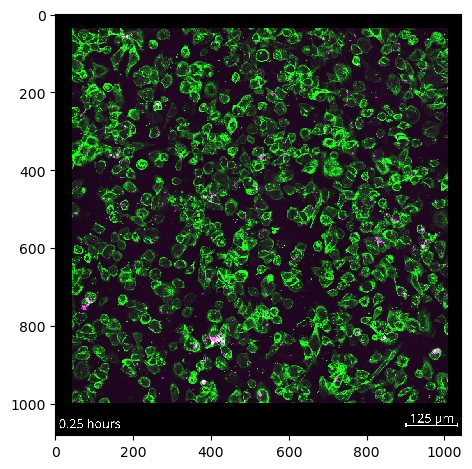

Rendering frames...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [19:51<00:00, 11.91s/it]


Rendering frames...


 31%|██████████████████████▎                                                | 118/376 [21:42<47:28, 11.04s/it]
TiffPages: invalid page offset 7722912
TiffPages: invalid page offset 7722912
TiffPages: invalid page offset 7722912
TiffPages: invalid page offset 7722912
Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/napari/_qt/widgets/qt_dims_slider.py", line 120, in _set_slice_from_label
    self.dims.set_current_step(self.axis, val)
  File "/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/napari/components/dims.py", line 290, in set_current_step
    self.current_step = full_current_step
  File "/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/napari/utils/events/evented_model.py", line 326, in __setattr__
    emitter(value=after)  # emit event
  File "/home/dayn/miniconda3/envs/brassica/lib/python3.9/site-packages/napari/utils/events/event.py", line 768, in __call__
    self._invoke_callback(cb, eve

In [107]:
imshow(viewer.screenshot())

In [55]:
viewer.dims.current_step = (187, cam_coords[-2], cam_coords[-1])
viewer.camera.zoom = zoom#*0.95
fn = os.path.join('/home/dayn/test.png')
imsave(fn, viewer.screenshot())

In [ ]:
### save image sequence
for t in tqdm(range(len(images)), desc = f'Saving animation'):
    fn = os.path.join(os.path.join(output_dir, f't_{t}.png'))
    if os.path.exists(fn):
        continue
    viewer.dims.current_step = (t, cam_coords[-2], cam_coords[-1])
    viewer.camera.zoom = zoom#*0.95
    imsave(fn, viewer.screenshot())
    animation.capture_keyframe(steps = 1)
animation.animate(os.path.join(output_dir, 'test_fullstack_labels.mp4'), canvas_only=True, fps = 20, quality = 9)

In [ ]:
### save image sequence
for t in tqdm(range(len(images)), desc = f'Saving animation'):
    fn = os.path.join(os.path.join(output_dir, f't_{t}.png'))
    if os.path.exists(fn):
        continue
    viewer.dims.current_step = (t, cam_coords[-2], cam_coords[-1])
    viewer.camera.zoom = zoom#*0.95
    imsave(fn, viewer.screenshot())
    animation.capture_keyframe(steps = 1)
animation.animate(os.path.join(output_dir, 'test_fullstack_labels.mp4'), canvas_only=True, fps = 20, quality = 9)

In [30]:
from skimage.io import imread

In [37]:
imread('/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/users/dayn/macrohet_nemo/macrohet_images/NDXXXX_optimisation/ND0000__2023-08-04T15_27_41-Measurement 1/Images/r02c10f02p03-ch1sk18fk1fl1.tiff')

array([[ 108,  108,  117, ...,  877, 1012, 1282],
       [ 118,  111,  128, ...,  892, 1091, 1427],
       [ 111,  100,  117, ...,  876, 1071, 1447],
       ...,
       [ 656,  607,  573, ...,   98,  101,  103],
       [ 629,  617,  565, ...,  109,  112,  117],
       [ 587,  585,  554, ...,  101,  105,  107]], dtype=uint16)

In [ ]:
### save image sequence
for t in tqdm(range(len(images)), desc = f'Saving animation'):
    viewer.dims.current_step = (t, cam_coords[-2], cam_coords[-1])
    viewer.camera.zoom = zoom#*0.95
    fn = os.path.join(f'/home/dayn/ND0000_animation_test/t_{t}.png')
    imsave(fn, viewer.screenshot())
    animation.capture_keyframe(steps = 1)
animation.animate(os.path.join(output_dir, '3.9.test_fullstack_labels.mp4'), canvas_only=True, fps = 20, quality = 9)

In [20]:
# viewer.camera.center = (0, 3023.5, 3023.5)
viewer.dims.current_step = (0, 3023, 3023)
animation.capture_keyframe()
viewer.dims.current_step = (375, 3023, 3023)
animation.capture_keyframe(steps = 375)
animation.animate(os.path.join(output_dir, 'test_fullstack_labels.mp4'), canvas_only=True, fps = 20, quality = 9)

Rendering frames...


100%|███████████████████████████████████████████████████| 766/766 [6:31:43<00:00, 30.68s/it]


In [ ]:
from macrohet import notify

In [ ]:
notify.send_sms('two videos saved out')

In [ ]:
output_dir = '/run/user/30046150/gvfs/google-drive:host=gmail.com,user=nthndy/13iZkrWWM5tgb0r0IG-waR97cjBGOM8mi'

In [ ]:
animation = Animation(viewer)

In [ ]:
viewer.camera.center = (0, 3023.5, 3023.5)
viewer.dims.current_step = (0, 3023, 3023)
animation.capture_keyframe()
viewer.dims.current_step = (375, 3023, 3023)
animation.capture_keyframe(steps = 375)
animation.animate(os.path.join(output_dir, 'test_fullstack.mp4'), canvas_only=True, fps = 20, quality = 9)

In [ ]:
from macrohet import notify

In [ ]:
notify.send_sms('quick version complete online')

### Add additional annotations

In [25]:
visualise.highlight_cell(1251, viewer, tracks)

<Points layer 'cell 1251' at 0x7f235d482790>

In [62]:
viewer.add_tracks(napari_filtered_tracks, scale = (1,5.04,5.04),)

<Tracks layer 'napari_filtered_tracks [2]' at 0x7ff4e5a32430>

In [25]:
viewer.layers['napari_filtered_tracks'].scale = (30, 5.04, 5.04)

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/action_manager.py", line 227, in <lambda>
    button.clicked.connect(lambda: self.trigger(name))
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/action_manager.py", line 427, in trigger
    return self._actions[name].injected()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/in_n_out/_store.py", line 773, in _exec
    result = func(**{**_kwargs, **bound.arguments})
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/image/_image_key_bindings.py", line 33, in orient_plane_normal_along_x
    orient_plane_normal_around_cursor(layer, plane_normal=(0, 0, 1))
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/utils/interactivity_utils.py", line 126, in orient_plane_normal_around_cursor
    view_direction = layer._world_to_displayed_data_ray(
  File "/home/dayn/minic

In [32]:
viewer.layers['napari_filtered_tracks'].axis_labels=["time", "y", "x"]

In [29]:
viewer.add_tracks(ds_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
                    name="hacky downscaled tracks", 
                    blending="translucent",
                    visible=True,
#                     scale = (1,1,1)
                )
# viewer.add_labels(ds_segmentation, 
#                  name = 'downscaled segmentation')

viewer.add_labels(ds_col_segmentation, 
                  name = 'downscaled coloured segmentation',
                  scale=(1, 1, 1,), 
#                   color={1:'yellow'}
                 )

viewer.add_labels(ds_col_segmentation_new_tracks, 
                  name = 'downscaled coloured segmentation new tracks',
                  scale=(1, 1, 1,), 
#                   color={1:'yellow'}
                 )

<Labels layer 'downscaled coloured segmentation new tracks' at 0x7f15c273ca30>